# Machine Laerning - All Models

In [1]:
import pandas as pd
import math 
import random
import numpy as np
import itertools as itt
import statsmodels.api as sm
import matplotlib.pyplot as plt
from numpy import median
from scipy import stats
from scipy.stats import norm
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_hastie_10_2

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras import optimizers
import keras.backend as K

Using TensorFlow backend.


# Define Function

## Logit

In [3]:
from sklearn.linear_model import LogisticRegression
#‘lbfgs’, ‘liblinear’
def logitR(penalty,C,solver,X_train, y_train, X_cols):
    np.random.seed(123)
    # fit model
    logmodel = LogisticRegression(penalty=penalty,C=C,solver=solver,max_iter=1000,tol=1e-5)
    logmodel.fit(X_train, y_train)

    #coefficient
    coef_sk = pd.DataFrame(logmodel.coef_).T
    coef_sk['feature'] = X_cols
    coef_sk.set_index('feature',inplace=True)

    #prediction
    #predictions = logmodel.predict(X_test)
    return logmodel,coef_sk

## Logit P-value

In [4]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return coefs, p 

<a id="feature"></a>
## Feature importance

In [5]:
def feature(model, X_train):
    series = pd.Series(model.feature_importances_, index=X_train.columns).nlargest(len(X_train.columns))
    series.plot(kind='barh')
    plt.title("Feature Importance", fontsize=15)
    plt.show()

## K-S Hist

In [6]:
def probhist(prob, y_test):
    (n, bins, p) = plt.hist(prob, bins=20)
    plt.show()

    #create KS measure table
    lower_score = bins[0:20]
    upper_score = bins[1:21]

    #create final_score table for model performance measure
    final_score = {'final_score': prob, 'd90_flag': y_test}
    final_score = pd.DataFrame(final_score)
    return lower_score, upper_score, final_score

<a id="kshist"></a>
## K-S Test

In [7]:
def KS(lower_score, upper_score, final_score):
    
    #seperate dataset into default and nondefault dataset
    default = final_score[final_score['d90_flag']== 1]
    nondefault = final_score[final_score['d90_flag']== 0]


    KS_measure = pd.DataFrame({'lower_score': lower_score, 'upper_score': upper_score })

    #create number of default and non-default columns
    def countdef(a):
        count = 0
        for i in default['final_score']:
            if (i < a[1]) & (i > a[0]):
                count +=1
        return count

    def countnondef(a):
        count = 0
        for i in nondefault['final_score']:
            if (i < a[1]) & (i > a[0]):
                count +=1
        return count

    KS_measure['num_default'] = KS_measure[['lower_score','upper_score']].apply(countdef,axis=1)
    KS_measure['num_nondefault'] = KS_measure[['lower_score','upper_score']].apply(countnondef,axis=1)

    KS_measure['default_rate'] = KS_measure['num_default'].apply(lambda x: x/default.shape[0])
    KS_measure['nondefault_rate'] = KS_measure['num_nondefault'].apply(lambda x: x/nondefault.shape[0])

    KS_measure['cum_default'] = KS_measure['default_rate'].cumsum()
    KS_measure['cum_nondefault'] = KS_measure['nondefault_rate'].cumsum()

    KS_measure['K_S'] = KS_measure['cum_default'] - KS_measure['cum_nondefault']

    KS_max = round(KS_measure['K_S'].max()*100,1)

    KSmax_score = float(KS_measure[KS_measure['K_S']==KS_measure['K_S'].max()]['lower_score'])

    #visualize the KS measure
    plt.plot(KS_measure['lower_score'], KS_measure['cum_default'], color='red', label='default')
    plt.plot(KS_measure['lower_score'], KS_measure['cum_nondefault'], color='blue', label='non-default')
    plt.legend()  

    plt.xlabel('score')
    plt.ylabel('Percentage of Loans')
    plt.vlines(KSmax_score,0,1,linestyles='dashdot')

    plt.annotate("K-S max:%5.1f"%(KS_max)+"%", 
                 xy=(KSmax_score, 0.6), xytext=(KSmax_score+20, 0.6),
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
    plt.title('K_S Measure, K_S max=%5.1f'%KS_max)
    plt.show()
    
    #print(KS_measure)
    
    return KS_max

In [8]:
# def KS_xgb(lower_score, upper_score, final_score):
    
#     #seperate dataset into default and nondefault dataset
#     default = final_score[final_score['d90_flag']== 1]
#     nondefault = final_score[final_score['d90_flag']== 0]


#     KS_measure = pd.DataFrame({'lower_score': lower_score, 'upper_score': upper_score })

#     #create number of default and non-default columns
#     def countdef(a):
#         count = 0
#         for i in default['final_score']:
#             if (i < a[1]) & (i > a[0]):
#                 count +=1
#         return count

#     def countnondef(a):
#         count = 0
#         for i in nondefault['final_score']:
#             if (i < a[1]) & (i > a[0]):
#                 count +=1
#         return count

#     KS_measure['num_default'] = KS_measure[['lower_score','upper_score']].apply(countdef,axis=1)
#     KS_measure['num_nondefault'] = KS_measure[['lower_score','upper_score']].apply(countnondef,axis=1)

#     KS_measure['default_rate'] = KS_measure['num_default'].apply(lambda x: x/default.shape[0])
#     KS_measure['nondefault_rate'] = KS_measure['num_nondefault'].apply(lambda x: x/nondefault.shape[0])

#     KS_measure['cum_default'] = KS_measure['default_rate'].cumsum()
#     KS_measure['cum_nondefault'] = KS_measure['nondefault_rate'].cumsum()

#     KS_measure['K_S'] = KS_measure['cum_default'] - KS_measure['cum_nondefault']

#     KS_max = round(KS_measure['K_S'].max()*100,1)

#     KSmax_score = KS_measure[KS_measure['K_S']==KS_measure['K_S'].max()]['lower_score'] ###no need for 'float'

#     #visualize the KS measure
#     plt.plot(KS_measure['lower_score'], KS_measure['cum_default'], color='red', label='default')
#     plt.plot(KS_measure['lower_score'], KS_measure['cum_nondefault'], color='blue', label='non-default')
#     plt.legend()  

#     plt.xlabel('score')
#     plt.ylabel('Percentage of Loans')
#     plt.vlines(KSmax_score,0,1,linestyles='dashdot')

#     plt.annotate("K-S max:%5.1f"%(KS_max) +"%", 
#                  xy=(KSmax_score, 0.6), xytext=(KSmax_score+20, 0.6),
#                 arrowprops=dict(arrowstyle="->",
#                                 connectionstyle="arc3"))
#     plt.title('K_S Measure, K_S max=%5.1f'%KS_max)
#     plt.show()
    
#     #print(KS_measure)
    
#     return KS_max

<a id="auc"></a>
## AUC

In [9]:
def auc(model, X_test, y_test):
    y_score = model.predict_proba(X_test)
    y_true = y_test
    auc = roc_auc_score(y_true, y_score[:,1])
    return auc 

In [10]:
def auc_xgb(model, X_test, y_test):
    y_score = model.predict(X_test)
    y_true = y_test
    auc = roc_auc_score(y_true, y_score)
    return auc

<a id="roc"></a>
## ROC

In [11]:
def ROC(model, X_test, y_test, auc_model):
    gbrt_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, color = 'r', label='Model (area = %0.4f)' % auc_model)
    plt.plot([0, 1], [0, 1],'b--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC', fontsize=15)
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    plt.show()
    for i in range(len(fpr)):
        if abs(fpr[i] - 0.2) < 1e-2:
            print ('When fpr = 0.2, tpr = ', tpr[i])
            break
    opt_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
    print('Best Threshold=%f' % (thresholds[opt_idx ]))
    return thresholds[opt_idx ], tpr, fpr

In [12]:
 def ROC_xgb(model, X_test, y_test, auc_model):
        gbrt_roc_auc = roc_auc_score(y_test, model.predict(X_test))
        fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
        plt.figure()
        plt.plot(fpr, tpr, color = 'r', label='Model (area = %0.4f)' % auc_model)
        plt.plot([0, 1], [0, 1],'b--', label='Baseline')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC', fontsize=15)
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC')
        plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
        plt.show()
        for i in range(len(fpr)):
            if abs(fpr[i] - 0.2) < 1e-2:
                print ('When fpr = 0.2, tpr = ', tpr[i])
            break

        opt_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
        print('Best Threshold=%f' % (thresholds[opt_idx ]))
        return thresholds[opt_idx ], tpr, fpr

<a id="cp"></a>
## Classificatoin Report

In [13]:
def cp(model, X_test, y_test, threshold): 
    y_prob = model.predict_proba(X_test)[:,1]
    predict_mine = np.where(y_prob > threshold, 1, 0)
    print(classification_report(y_test, predict_mine))
    print('recall=%0.5f' % recall_score(y_test, predict_mine))
    print('precision=%0.5f' % precision_score(y_test, predict_mine))
    print('f1_score=%0.5f' % f1_score(y_test, predict_mine))
    cm = confusion_matrix(y_test,predict_mine) 
    return y_prob, cm

In [112]:
def cp_xgb(model, X_test, y_test, threshold): 
    y_prob = model.predict(X_test)
    predict_mine = np.where(y_prob > threshold, 1, 0)
    print(classification_report(y_test, predict_mine))  
    print('recall=%0.5f' % recall_score(y_test, predict_mine))
    print('precision=%0.5f' % precision_score(y_test, predict_mine))
    print('f1_score=%0.5f' % f1_score(y_test, predict_mine))
    cm = confusion_matrix(y_test,predict_mine) 
    return y_prob, cm

<a id="cm"></a>
## Confusion Matrix

In [14]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    thresh = cm.max() / 2.
    for i, j in itt.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",  fontsize=12
                 )
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

## Performance (KS, ROC, AUC, Confusion Matrix, Classification Report)

In [15]:
def run_all(model, X_train, y_train, X_test, y_test):
    
    ### frature importance
    feature_model = feature(model, X_train)
    
    ### K-S Test
    y_pred_model = model.predict(X_test)
    log_prob_model = -(model.predict_log_proba(X_test)[:, 1] )*10
    lower_score, upper_score, final_score = probhist(log_prob_model, y_test)
    ks_model = KS(lower_score, upper_score, final_score)

    ### AUC
    auc_model = auc(model, X_test, y_test)
    print(auc_model)

    ### ROC
    best_threshold, tpr, fpr = ROC(model, X_test, y_test, auc_model)

    ### Threshold from Logit Percentage
    y_prob = model.predict_proba(X_test)[:,1]
    y_prob_sort = np.sort(y_prob)
    plt.plot(y_prob_sort)
    plt.show()
    
    index = 15751
    threshold_index = y_prob_sort[-(index+1)]
    y_prob, cm = cp(model, X_test, y_test, threshold_index)

    plot_confusion_matrix(cm, classes=[0,1], title='Confusion matrix')
    
    return y_prob

In [16]:
def run_Dtree(model, X_test, y_test):

    ### frature importance
    feature_model = feature(model, X_train)
    
    ### AUC
    auc_model = auc(model, X_test, y_test)
    print('auc :', auc_model)

    ### ROC
    best_threshold, tpr, fpr = ROC(model, X_test, y_test, auc_model)

    ### Threshold from Logit Percentage  
    y_prob = model.predict_proba(X_test)[:,1]
    y_prob_sort = np.sort(y_prob)
    plt.plot(y_prob_sort)
    plt.show()
    
    index = 15751
    threshold_index = y_prob_sort[-(index+1)]
    y_prob, cm = cp(model, X_test, y_test, threshold_index)


    plot_confusion_matrix(cm, classes=[0,1], title='Confusion matrix')

In [17]:
def run_all_xgb(model, X_trian, y_train, X_test, y_test):
    
#     y_pred_model = model.predict(X_test)
#     log_prob_model = -np.log(y_pred_model)*10
#     lower_score, upper_score, final_score = probhist(y_pred_model, y_test)
#     ks_model = KS_xgb(lower_score, upper_score, final_score)
   
    def auc_xgb(model, X_test, y_test):
        y_score = model.predict(X_test)
        y_true = y_test
        auc = roc_auc_score(y_true, y_score)
        return auc

    def ROC_xgb(model, X_test, y_test, auc_model):
        gbrt_roc_auc = roc_auc_score(y_test, model.predict(X_test))
        fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
        plt.figure()
        plt.plot(fpr, tpr, color = 'r', label='Model (area = %0.4f)' % auc_model)
        plt.plot([0, 1], [0, 1],'b--', label='Baseline')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC', fontsize=15)
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC')
        plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
        plt.show()
        for i in range(len(fpr)):
            if abs(fpr[i] - 0.2) < 1e-2:
                print ('When fpr = 0.2, tpr = ', tpr[i])
            break

        opt_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
        print('Best Threshold=%f' % (thresholds[opt_idx ]))
        return thresholds[opt_idx ], tpr, fpr

    def cp_xgb(model, X_test, y_test, threshold): 
        y_prob = model.predict(X_test)
        predict_mine = np.where(y_prob > threshold, 1, 0)
        print(classification_report(y_test, predict_mine))
        print('recall=%0.5f' % recall_score(y_test, predict_mine))
        print('precision=%0.5f' % precision_score(y_test, predict_mine))
        print('f1_score=%0.5f' % f1_score(y_test, predict_mine))
        cm = confusion_matrix(y_test,predict_mine) 
        return y_prob, cm
    
    ### AUC
    auc_model = auc_xgb(model, X_test, y_test)
    print(auc_model)

    ### ROC
    best_threshold, tpr, fpr = ROC_xgb(model, X_test, y_test, auc_model)

    ### Threshold from Logit Percentage
    y_pred_model = model.predict(X_test)
    y_prob_log = np.log(y_pred_model)
    y_prob_sort_log = np.sort(y_prob_log)
    plt.plot(y_prob_sort_log)
    plt.show()
    
    index = 15751
    y_prob_sort = np.sort(y_pred_model)
    threshold_index = y_prob_sort[-(index+1)]

    y_prob, cm = cp_xgb(model, X_test, y_test, threshold_index)

    plot_confusion_matrix(cm, classes=[0,1], title='Confusion matrix')
    
    return y_prob

In [18]:
def run_logit(model, X_train, y_train, X_test, y_test):
    
    ### K-S Test
    y_pred_model = model.predict(X_test)
    log_prob_model = -(model.predict_log_proba(X_test)[:, 1] )*10
    lower_score, upper_score, final_score = probhist(log_prob_model, y_test)
    ks_model = KS(lower_score, upper_score, final_score)

    ### AUC
    auc_model = auc(model, X_test, y_test)
    print(auc_model)

    ### ROC
    best_threshold, tpr, fpr = ROC(model, X_test, y_test, auc_model)

    ### Threshold from Logit Percentage
    y_prob = model.predict_proba(X_test)[:,1]
    y_prob_sort = np.sort(y_prob)
    plt.plot(y_prob_sort)
    plt.show()
    
    index = 15751
    threshold_index = y_prob_sort[-(index+1)]
    y_prob, cm = cp(model, X_test, y_test, threshold_index)

    plot_confusion_matrix(cm, classes=[0,1], title='Confusion matrix')
    
    return y_prob

## Swap Sets

In [19]:
def swap_set(y_pred_model):
    
    #Logistic Prediction
    opt_prob = 0.1108941788607104
    predict_mine = np.where(y_prob_logit > opt_prob, 1, 0)
    y_pred_logit = predict_mine
    
    #Combine predict_y of two models
    swap = {'y_pred_logit':y_pred_logit, 'y_pred_model':y_pred_model }
    swap = pd.DataFrame(swap)

    #calculate swap-in and swap-out population
    swap_in = swap[(swap['y_pred_logit']==1) & (swap['y_pred_model']==0)]
    swap_out = swap[(swap['y_pred_logit']==0) & (swap['y_pred_model']==1)]
    approved = swap[(swap['y_pred_logit']==0) & (swap['y_pred_model']==0)]
    declined = swap[(swap['y_pred_logit']==1) & (swap['y_pred_model']==1)]
    Total_approved = len(approved) + len(swap_out)
    Total_declined = len(declined) + len(swap_in)
    Total_approved_gbrt = len(approved) + len(swap_in)
    Total_declined_gbrt = len(declined) + len(swap_out)
    Total = Total_approved + Total_declined

    #Swap Sets Matrix
    swap_matrix_model = np.matrix([[len(approved), len(swap_out), Total_approved], 
                        [len(swap_in), len(declined), Total_declined],
                        [Total_approved_gbrt, Total_declined_gbrt, Total]])
    print('Swap Sets Matrix')
    print(swap_matrix_model)
    
    #swap_graph = plot_confusion_matrix(swap_matrix_model, classes=['Approved','Declined','Total'], title='Swap Sets Matrix')
   
    
    return swap_matrix_model#, swap_graph

## Bad Rates

In [20]:
def badrate(gbrt_pred_y, sawp_matrix, y_test):
    
    opt_prob = 0.1108941788607104
    predict_mine = np.where(y_prob_logit > opt_prob, 1, 0)
    y_pred_logit = predict_mine
   
    #combine actual default and predicted default from two models
    total_y = {'y_test': y_test, 
               'y_pred_logit':y_pred_logit, 
               'gbrt_pred_y':gbrt_pred_y}
    total_y = pd.DataFrame(total_y)

    #calculate bad rates
    logit_approved_totalbad = len(total_y[(total_y['y_test']==1) & (total_y['y_pred_logit']==0)])
    logit_declined_totalbad = len(total_y[(total_y['y_test']==1) & (total_y['y_pred_logit']==1)])
    new_approved_totalbad = len(total_y[(total_y['y_test']==1) & (total_y['gbrt_pred_y']==0)])
    new_declined_totalbad = len(total_y[(total_y['y_test']==1) & (total_y['gbrt_pred_y']==1)])
    both_approved_bad = len(total_y[(total_y['y_test']==1) & (total_y['y_pred_logit']==0)& (total_y['gbrt_pred_y']==0)])
    both_declined_bad = len(total_y[(total_y['y_test']==1) & (total_y['y_pred_logit']==1)& (total_y['gbrt_pred_y']==1)])
    swapin_bad = len(total_y[(total_y['y_test']==1) & (total_y['y_pred_logit']==1)& (total_y['gbrt_pred_y']==0)])
    swapout_bad = len(total_y[(total_y['y_test']==1) & (total_y['y_pred_logit']==0)& (total_y['gbrt_pred_y']==1)])
    totalbad = len(total_y[(total_y['y_test']==1)])
    badnumber_matrix = np.array([[both_approved_bad, swapout_bad, logit_approved_totalbad], 
                            [swapin_bad, both_declined_bad, logit_declined_totalbad],
                            [new_approved_totalbad, new_declined_totalbad,totalbad ]])

    badrate_matrix = np.around(badnumber_matrix/sawp_matrix, decimals=5)*100
    print('Bad Rates Matrix (in %)')
    print(badrate_matrix)
    
    #badrate_graph = plot_confusion_matrix(badrate_matrix, classes=['Approved','Declined','Total'], title='Bad Rate Matrix')
    return badrate_matrix#, badrate_graph

## Calculating Dollar Value Loss

In [21]:
def loss(model, y_prob_logit, percentage, X_test, y_test):

    y_prob_logit_sort = np.sort(y_prob_logit)
    index = int(len(y_prob_logit_sort)*percentage)
    print('index:', index)
    opt_prob = y_prob_logit_sort[-(index)+1]

    predict_mine = np.where(y_prob_logit > opt_prob, 1, 0)
    y_pred_logit = predict_mine


    y_prob_model = model.predict_proba(X_test)[:,1]
    y_prob_model_sort = np.sort(y_prob_model)
    model_threshold = y_prob_model_sort[-(index+1)]
    y_pred_model = np.where(y_prob_model > model_threshold, 1, 0)
    print('Model threshold:', model_threshold)

    
    total_y = {'y_test': y_test, 
               'y_pred_logit':y_pred_logit, 
               'y_pred_model':y_pred_model}
    total_y = pd.DataFrame(total_y)
      
    upb_median = 160000
    upb_median_default = 162000
    
    ##############################################################################
    ###Calculate T1 Error Loss
    gfee = 0.0055
    duration = 4 

    #Logistic Model
    n_t1_logit = len(total_y[(total_y['y_test']==0) & (total_y['y_pred_logit']==1)])
    
    # Gradient Boosing Model
    n_t1_model = len(total_y[(total_y['y_test']==0) & (total_y['y_pred_model']==1)]) 

    #opportunity cost for each loan
    loss_reject = int(upb_median*gfee*duration)
    loss_reject_logit = loss_reject*n_t1_logit
    loss_reject_model = loss_reject*n_t1_model
    incre_reject_loss = loss_reject_model - loss_reject_logit

    print('cost of T1 error for each loan:', loss_reject)
    print('number of T1 error from Logistic Model:', n_t1_logit)
    print('number of T1 error from ML Model:', n_t1_model)
    print('incremental number of T1 error of ML Model:', n_t1_model - n_t1_logit)
    print()
    print('T1 loss of Logistic Model:', loss_reject_logit)
    print('T1 loss of ML Model:', loss_reject_model)
    print('T1 incremental credit losses of ML Model:', incre_reject_loss)
    print()
    
    ##############################################################################
    ###Calculate T2 Error Loss
    
    #Logistic Model
    n_t2_logit = len(total_y[(total_y['y_test']==1) & (total_y['y_pred_logit']==0)])
   
    # Gradient Boosing Model
    n_t2_model = len(total_y[(total_y['y_test']==1) & (total_y['y_pred_model']==0)]) 
    
    actual_default = len(total_y[total_y['y_test']==1])/len(total_y)
    loss_rate = 0.25 
    
    loss_default = int(upb_median_default*loss_rate) 
    loss_default_logit = loss_default*n_t2_logit
    loss_default_model = loss_default*n_t2_model
    incre_default_loss = loss_default_model - loss_default_logit
    print('cost of T2 error for each loan:', int(loss_default))
    print('number of T2 error from Logistic Model:', n_t2_logit)
    print('number of T2 error from ML Model:', n_t2_model)
    print('incremental number of T2 error of ML Model:', n_t2_model - n_t2_logit)
    print()
    print('T2 loss of Logistic Model:', loss_default_logit)
    print('T2 loss of ML Model:', loss_default_model)
    print('T2 incremental credit losses of ML Model:', incre_default_loss)
    print()
    
    return loss_default_logit,  loss_default_model, loss_reject_logit, loss_reject_model, n_t1_logit, n_t1_model, n_t2_logit, n_t2_model

In [22]:
def loss_xgb(y_pred_proba_xgb, y_prob_logit, percentage, y_test):

    y_prob_logit_sort = np.sort(y_prob_logit)
    index = int(len(y_prob_logit_sort)*percentage)
    print('index:', index)
    opt_prob = y_prob_logit_sort[-(index)+1]

    predict_mine = np.where(y_prob_logit > opt_prob, 1, 0)
    y_pred_logit = predict_mine

    y_prob_model_sort = np.sort(y_pred_proba_xgb)
    model_threshold = y_prob_model_sort[-(index+1)]
    y_pred_model = np.where(y_pred_proba_xgb > model_threshold, 1, 0)
    print('Model threshold:', model_threshold)

    
    total_y = {'y_test': y_test, 
               'y_pred_logit':y_pred_logit, 
               'y_pred_model':y_pred_model}
    total_y = pd.DataFrame(total_y)
      
    upb_median = 160000
    upb_median_default = 162000
    
 ##############################################################################
    ###Calculate T1 Error Loss
    gfee = 0.0055
    duration = 4 

    #Logistic Model
    n_t1_logit = len(total_y[(total_y['y_test']==0) & (total_y['y_pred_logit']==1)])
   
    # Gradient Boosing Model
    n_t1_model = len(total_y[(total_y['y_test']==0) & (total_y['y_pred_model']==1)]) 

    #opportunity cost for each loan
    loss_reject = int(upb_median*gfee*duration)
    loss_reject_logit = loss_reject*n_t1_logit
    loss_reject_model = loss_reject*n_t1_model
    incre_reject_loss = loss_reject_model - loss_reject_logit

    print('cost of T1 error for each loan:', loss_reject)
    print('number of T1 error from Logistic Model:', n_t1_logit)
    print('number of T1 error from ML Model:', n_t1_model)
    print('incremental number of T1 error of ML Model:', n_t1_model - n_t1_logit)
    print()
    print('T1 loss of Logistic Model:', loss_reject_logit)
    print('T1 loss of ML Model:', loss_reject_model)
    print('T1 incremental credit losses of ML Model:', incre_reject_loss)
    print()
    
    ##############################################################################
    ###Calculate T2 Error Loss
   
    #Logistic Model
    n_t2_logit = len(total_y[(total_y['y_test']==1) & (total_y['y_pred_logit']==0)])
  
    # Gradient Boosing Model
    n_t2_model = len(total_y[(total_y['y_test']==1) & (total_y['y_pred_model']==0)]) 
    
    actual_default = len(total_y[total_y['y_test']==1])/len(total_y)
    loss_rate = 0.25 
    
    loss_default = int(upb_median_default*loss_rate) 
    loss_default_logit = loss_default*n_t2_logit
    loss_default_model = loss_default*n_t2_model
    incre_default_loss = loss_default_model - loss_default_logit
    print('cost of T2 error for each loan:', int(loss_default))
    print('number of T2 error from Logistic Model:', n_t2_logit)
    print('number of T2 error from ML Model:', n_t2_model)
    print('incremental number of T2 error of ML Model:', n_t2_model - n_t2_logit)
    print()
    print('T2 loss of Logistic Model:', loss_default_logit)
    print('T2 loss of ML Model:', loss_default_model)
    print('T2 incremental credit losses of ML Model:', incre_default_loss)
    print()
    
    return loss_default_logit,  loss_default_model, loss_reject_logit, loss_reject_model, n_t1_logit, n_t1_model, n_t2_logit, n_t2_model

## Dollar value loss by changing approval rate

In [23]:
def dollar_value(model):
    percentage_range = [0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
    loss_default_logit_list = []
    loss_default_model_list = []
    loss_reject_logit_list = []
    loss_reject_model_list = []
    n_t1_logit_list = []
    n_t1_model_list = []
    n_t2_logit_list = []
    n_t2_model_list = []

    for i in percentage_range:
        percentage = i
        print('when approval rate is', 1-i)
        print()
        loss_default_logit,  loss_default_model, loss_reject_logit, loss_reject_model , n_t1_logit, n_t1_model, n_t2_logit, n_t2_model = loss(model, y_prob_logit, percentage, X_test, y_test)

        loss_default_logit_list.append(loss_default_logit)
        loss_default_model_list.append(loss_default_model)
        loss_reject_logit_list.append(loss_reject_logit)
        loss_reject_model_list.append(loss_reject_model)
        n_t1_logit_list.append(n_t1_logit)
        n_t1_model_list.append(n_t1_model)
        n_t2_logit_list.append(n_t2_logit)
        n_t2_model_list.append(n_t2_model)
        print('--------------------------------------------------------------------')
    
    return loss_default_logit_list, loss_default_model_list, loss_reject_logit_list, loss_reject_model_list, n_t1_logit_list, n_t1_model_list, n_t2_logit_list, n_t2_model_list

In [24]:
def dollar_value_xgb(model):
    percentage_range = [0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
    loss_default_logit_list = []
    loss_default_model_list = []
    loss_reject_logit_list = []
    loss_reject_model_list = []
    n_t1_logit_list = []
    n_t1_model_list = []
    n_t2_logit_list = []
    n_t2_model_list = []
    
    
    for i in percentage_range:
        percentage = i
        print('when approval rate is', 1-i)
        print()
        loss_default_logit,  loss_default_model, loss_reject_logit, loss_reject_model , n_t1_logit, n_t1_model, n_t2_logit, n_t2_model = loss_xgb(y_pred_proba_xgb, y_prob_logit, percentage, y_test)
        loss_default_logit_list.append(loss_default_logit)
        loss_default_model_list.append(loss_default_model)
        loss_reject_logit_list.append(loss_reject_logit)
        loss_reject_model_list.append(loss_reject_model)
        n_t1_logit_list.append(n_t1_logit)
        n_t1_model_list.append(n_t1_model)
        n_t2_logit_list.append(n_t2_logit)
        n_t2_model_list.append(n_t2_model)
        print('--------------------------------------------------------------------')
    
    return loss_default_logit_list, loss_default_model_list, loss_reject_logit_list, loss_reject_model_list, n_t1_logit_list, n_t1_model_list, n_t2_logit_list, n_t2_model_list

# Import data

In [25]:
#Data for Machine Learning Model
sample = pd.read_csv('Logit_Model.csv')

#Data for Logistic Model
sample2 = pd.read_csv('final_sample_uni_nooutlier2.csv')
sample2 = sample2[~(sample2['fico'] <= 550)]

/Users/angela004327/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,20,23,34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/angela004327/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,25,28,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data for Logit

In [26]:
# Create Splines
sample2['fico_630'] = sample2['fico'].apply(lambda x: max(x-629,0))
sample2['fico_640'] = sample2['fico'].apply(lambda x: max(x-639,0))
sample2['fico_680'] = sample2['fico'].apply(lambda x: max(x-679,0))
sample2['fico_710'] = sample2['fico'].apply(lambda x: max(x-709,0))
sample2['fico_740'] = sample2['fico'].apply(lambda x: max(x-739,0))

sample2['dti_15'] = sample2['dti'].apply(lambda x: max(x-14,0))
sample2['dti_35'] = sample2['dti'].apply(lambda x: max(x-34,0))
sample2['dti_40'] = sample2['dti'].apply(lambda x: max(x-39,0))
sample2['dti_55'] = sample2['dti'].apply(lambda x: max(x-54,0))

sample2['ocltv_50'] = sample2['ocltv'].apply(lambda x: max(x-49,0))
sample2['ocltv_75'] = sample2['ocltv'].apply(lambda x: max(x-74,0))
sample2['ocltv_85'] = sample2['ocltv'].apply(lambda x: max(x-84,0))
sample2['ocltv_95'] = sample2['ocltv'].apply(lambda x: max(x-94,0))

sample2['orig_rt_6'] = sample2['orig_rt'].apply(lambda x: max(x-5.99,0))
sample2['orig_rt_7'] = sample2['orig_rt'].apply(lambda x: max(x-6.99,0))


#get dummies
cat_vars=['channel','flag_fthb','loan_purpose', 'prop_type', 'occpy_sts']

sample2=pd.get_dummies(sample2,
                   prefix_sep='_',
                   drop_first=False,
                   columns=cat_vars)

#Define Variables
X_cols_logit = ['fico',
             'fico_640', 
             #'fico_680',
             'fico_710', 
             #'fico_740',
             'dti',
             'dti_40',
             #'dti_15','dti_35', #'dti_55',
             #'ocltv_50', 
             'ocltv',
             'ocltv_75', 'ocltv_85', 'ocltv_95',
             #'orig_rt',
             'rel_median_orig_upb',
             #'rel_mean_orig_upb',
             'num_unit',
             #'num_unit_1','num_unit_2',
             'cnt_borr',
             'flag_fthb_Y', 
             'occpy_sts_I', 'occpy_sts_S',
             'channel_B', 'channel_C',
             'prop_type_CO', 'prop_type_PU',
             'sato',
             'loan_purpose_C'
            #,'loan_purpose_P', 'loan_purpose_N'
              ] 

train_logit = sample2[sample2['orig_year'] % 2 == 0]
test_logit = sample2[sample2['orig_year'] % 2 == 1]

X_train_logit = train_logit[X_cols_logit]
X_test_logit = test_logit[X_cols_logit]

y_train_logit = train_logit['d90_flag']
y_test_logit = test_logit['d90_flag']

## Data for Machine Learning

In [27]:
# Define Variables
X_cols = ['fico',
          'dti',
          'ocltv',
         #'orig_rt',
         'rel_median_orig_upb',
         #'rel_mean_orig_upb',
         'num_unit',
         #'num_unit_1','num_unit_2',
         'cnt_borr',
         'flag_fthb_Y', 
         'occpy_sts_I', 'occpy_sts_S',# 'occpy_sts_P',
         'channel_B', 'channel_C', #'channel_R',
         'prop_type_CO', 'prop_type_PU', 
         #'prop_type_SF',
         'sato',
         'loan_purpose_C'
         #,'loan_purpose_P', 'loan_purpose_N'
          ] 

train = sample[sample['orig_year'] % 2 == 0]
test = sample[sample['orig_year'] % 2 == 1]

X_train = train[X_cols]
X_test = test[X_cols]

y_train = train['d90_flag']
y_test = test['d90_flag']

In [28]:
(y_test==1).sum()/len(y_test)

0.05795228008970845

# Logistic Model

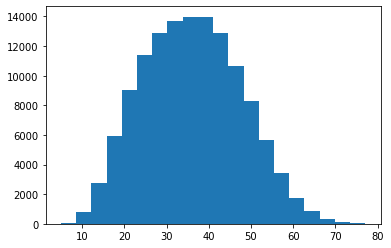

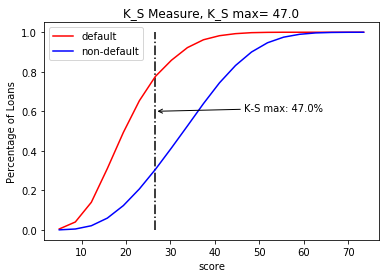

0.8078810909357959


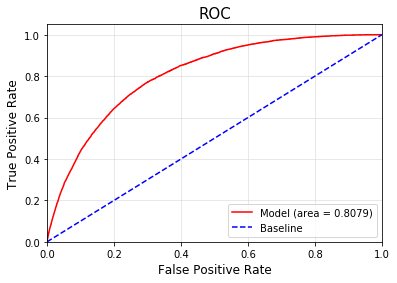

When fpr = 0.2, tpr =  0.626175759204515
Best Threshold=0.052408


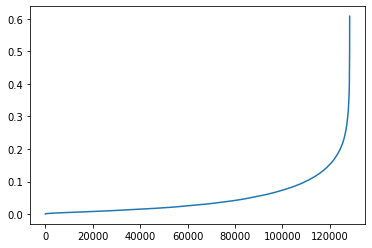

              precision    recall  f1-score   support

           0       0.96      0.90      0.93    120974
           1       0.21      0.45      0.29      7442

    accuracy                           0.87    128416
   macro avg       0.59      0.67      0.61    128416
weighted avg       0.92      0.87      0.89    128416

recall=0.44652
precision=0.21097
f1_score=0.28655


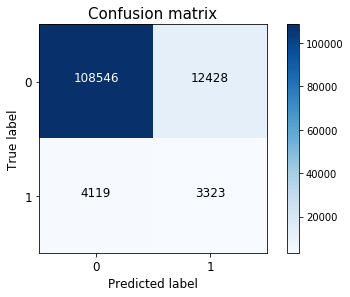

In [29]:
penalty = 'l2' 
C = 0.01
solver = 'liblinear'
logmodel,coef_sk = logitR(penalty,C,solver,X_train_logit, y_train_logit, X_cols_logit)
y_prob_logit = run_logit(logmodel, X_train_logit, y_train_logit, X_test_logit, y_test_logit)

In [30]:
coefs, p = logit_pvalue(logmodel, X_train_logit)
X_cols_inc = X_cols_logit[:]
X_cols_inc.insert(0,'Intercept')
p_value = pd.DataFrame({'feature':X_cols_inc, 'coeffienct':coefs, 'P_value':p.round(6)})
p_value 

,feature,coeffienct,P_value
0,Intercept,0.004315,0.995691
1,fico,-0.006511,0.000000
2,fico_640,-0.004299,0.010475
3,fico_710,-0.003858,0.000864
4,dti,0.014834,0.000000
5,dti_40,0.015107,0.000118
6,ocltv,0.025594,0.000000
7,ocltv_75,0.020016,0.006364
8,ocltv_85,-0.050531,0.000002
9,ocltv_95,0.154594,0.000000


# Machine Learning Model Performance

## Decision Tree

In [31]:
Dtree= DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state = 42)
Dtree = Dtree.fit(X_train, y_train)
score = Dtree.score(X_test, y_test)
print(score)
y_prob_Dtree = Dtree.predict_proba(X_test)[:,1]

0.9420477199102916


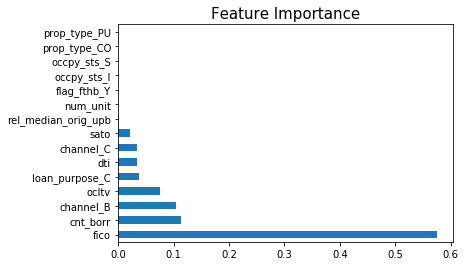

auc : 0.7789256741240109


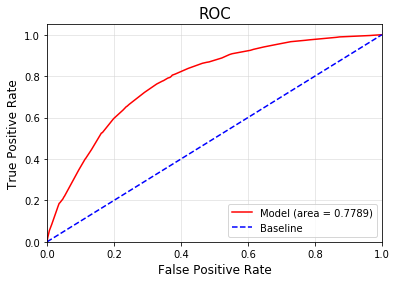

When fpr = 0.2, tpr =  0.5945982262832572
Best Threshold=0.063476


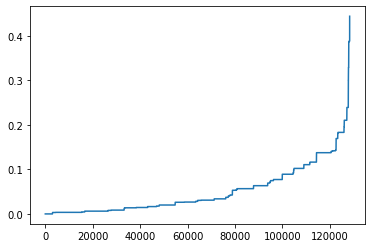

              precision    recall  f1-score   support

           0       0.96      0.91      0.93    120974
           1       0.18      0.35      0.24      7442

    accuracy                           0.87    128416
   macro avg       0.57      0.63      0.59    128416
weighted avg       0.91      0.87      0.89    128416

recall=0.34682
precision=0.18404
f1_score=0.24047


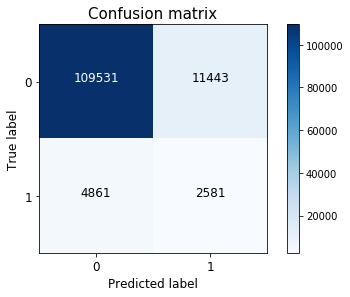

In [32]:
run_Dtree(Dtree, X_test, y_test)

0.7787450150473766


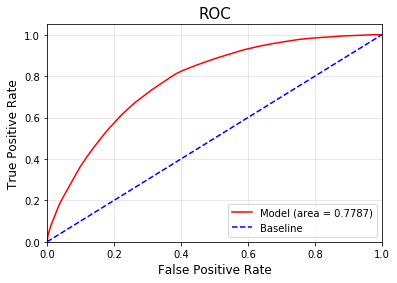

Best Threshold=0.063476
KS:0.426353


In [33]:
# performance on development sample
auc_train_dtree = auc(Dtree, X_train, y_train)
print(auc_train_dtree)
best_threshold, tpr, fpr = ROC(Dtree, X_train, y_train, auc_train_dtree)
print('KS:%.6f' % max(abs(tpr-fpr)))

## Random Forest

In [34]:
clf = RandomForestClassifier(n_estimators=450,
               max_features= 'auto',
               max_depth=10,
               min_samples_split= 5,
               min_samples_leaf= 4,
               bootstrap= True)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=450,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

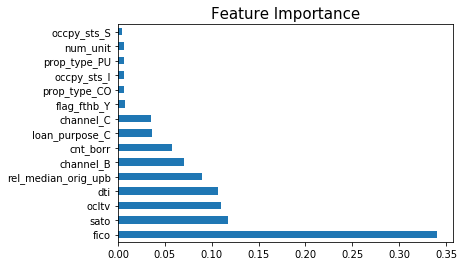

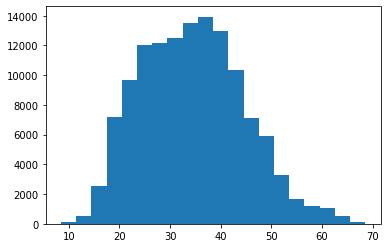

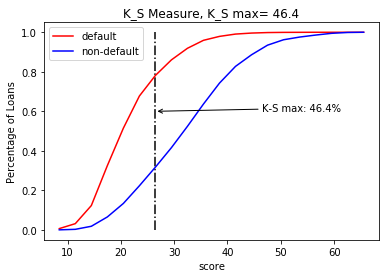

0.806100421199645


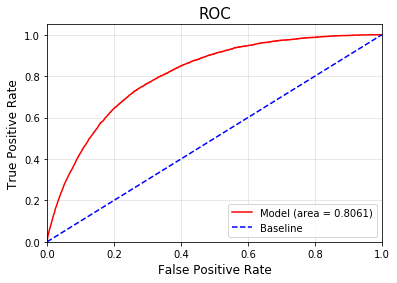

When fpr = 0.2, tpr =  0.6269819940876109
Best Threshold=0.060173


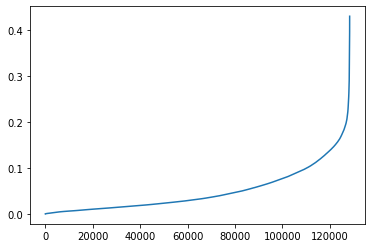

              precision    recall  f1-score   support

           0       0.96      0.90      0.93    120974
           1       0.21      0.44      0.28      7442

    accuracy                           0.87    128416
   macro avg       0.59      0.67      0.61    128416
weighted avg       0.92      0.87      0.89    128416

recall=0.43859
precision=0.20722
f1_score=0.28146


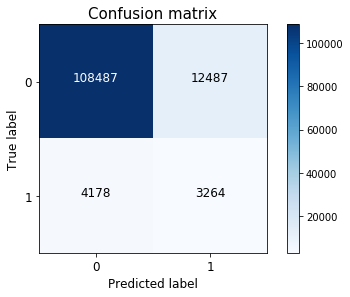

In [35]:
y_prob_clf = run_all(clf, X_train, y_train, X_test, y_test)

0.8497818026546593


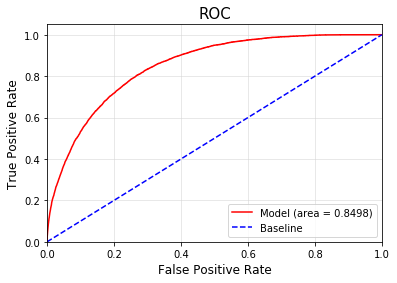

When fpr = 0.2, tpr =  0.7052199056460204
Best Threshold=0.068221
KS:0.535825


In [36]:
# performance on development sample
auc_train_clf = auc(clf, X_train, y_train)
print(auc_train_clf)
best_threshold, tpr, fpr = ROC(clf, X_train, y_train, auc_train_clf)
print('KS:%.6f' % max(abs(tpr-fpr)))

## Gradient Boosting

In [37]:
gbrt = GradientBoostingClassifier(max_depth=4, n_estimators=700, random_state=42, learning_rate=0.005,
                                  min_samples_split=100, min_samples_leaf=30, subsample=0.85, max_features=7)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.005, loss='deviance', max_depth=4,
                           max_features=7, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=30, min_samples_split=100,
                           min_weight_fraction_leaf=0.0, n_estimators=700,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.85, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [98]:
feature_im = pd.DataFrame(np.sort(gbrt.feature_importances_))

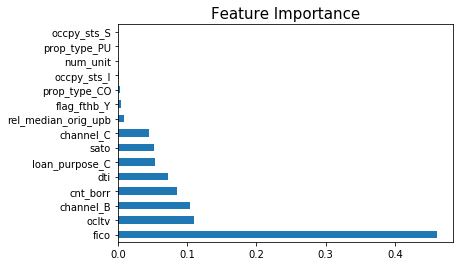

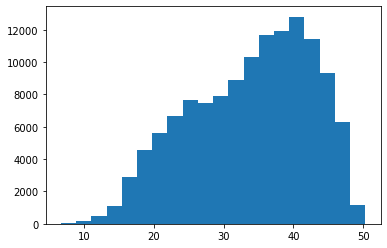

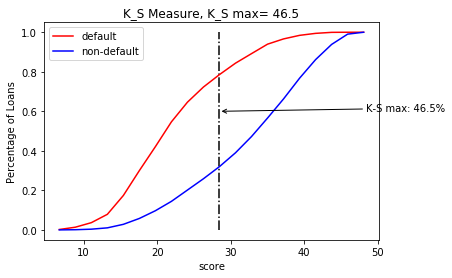

0.8071171847058609


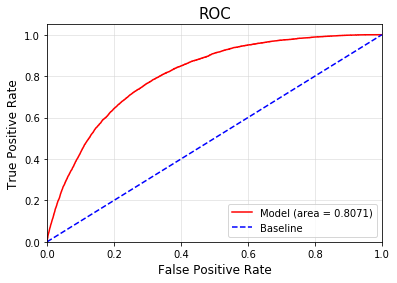

When fpr = 0.2, tpr =  0.6280569739317388
Best Threshold=0.055874


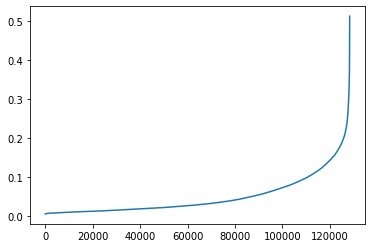

              precision    recall  f1-score   support

           0       0.96      0.90      0.93    120974
           1       0.21      0.44      0.28      7442

    accuracy                           0.87    128416
   macro avg       0.59      0.67      0.61    128416
weighted avg       0.92      0.87      0.89    128416

recall=0.44114
precision=0.20843
f1_score=0.28310


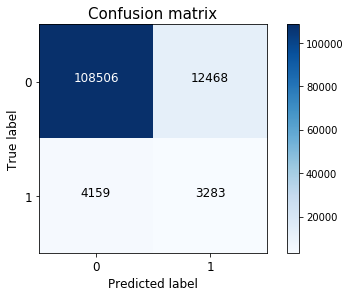

In [38]:
y_prob_gbrt = run_all(gbrt, X_train, y_train, X_test, y_test)

In [104]:
feature_im = pd.DataFrame(np.sort(gbrt.feature_importances_))
feature_clf = pd.DataFrame(np.sort(clf.feature_importances_))
print(feature_im.iloc[7:15].sum())
print(feature_clf.iloc[7:15].sum())

0    0.982982
dtype: float64
0    0.928001
dtype: float64


In [105]:
feature_clf

,0
0,0.004253
1,0.005962
2,0.006092
3,0.006522
4,0.006708
5,0.007536
6,0.034926
7,0.036290
8,0.057527
9,0.069973


0.7999273003700816


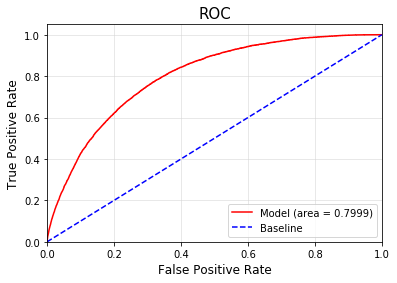

When fpr = 0.2, tpr =  0.6050829401917517
Best Threshold=0.056775
KS:0.455115


In [39]:
# performance on development sample
auc_train = auc(gbrt, X_train, y_train)
print(auc_train)
best_threshold, tpr, fpr = ROC(gbrt, X_train, y_train, auc_train)
print('KS:%.6f' % max(abs(tpr-fpr)))

## XGBoost

In [40]:
names = X_train.columns

dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

watchlist = [(dtrain,'train')]

params={'booster':'gbtree',#gblinear performs worse
    'objective': 'reg:linear',
    #'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth':4,
    'lambda':5,
    'alpha':5,
    'subsample':0.75,
    'colsample_bytree':0.5,
    'min_child_weight':7,
    'learning_rate': 0.1,
    'seed':2020,
    'nthread':1,
    'silent':1,
    #'base_score':0.75
    }

bst = xgb.train(params,dtrain,num_boost_round=100)#,evals=watchlist)
y_pred_proba_xgb = bst.predict(dtest)

0.8080583585545446


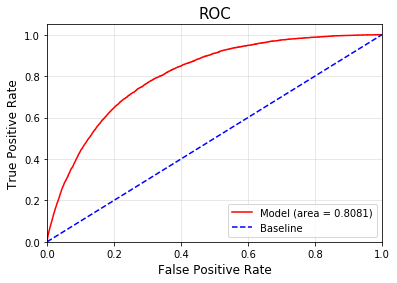

Best Threshold=0.062736


/Users/angela004327/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in log


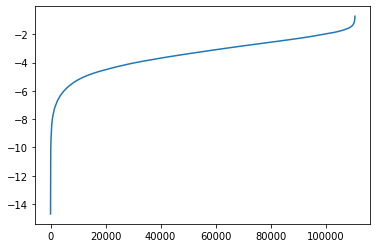

              precision    recall  f1-score   support

           0       0.96      0.90      0.93    120974
           1       0.21      0.45      0.29      7442

    accuracy                           0.87    128416
   macro avg       0.59      0.67      0.61    128416
weighted avg       0.92      0.87      0.89    128416

recall=0.44733
precision=0.21135
f1_score=0.28707


array([0.03150263, 0.04381201, 0.05491528, ..., 0.00591478, 0.01997784,
       0.01030597], dtype=float32)

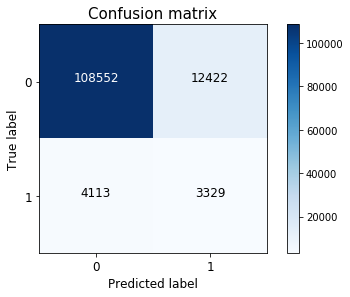

In [41]:
run_all_xgb(bst, dtrain, y_train, dtest, y_test)

0.8080583585545446


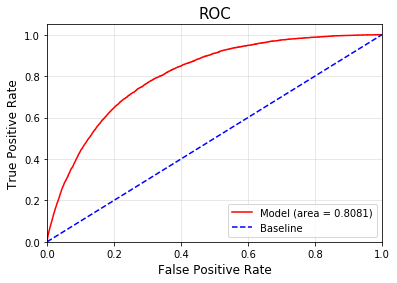

Best Threshold=0.062736
KS:0.468593


In [106]:
# performance on development sample
auc_test_xgb = auc_xgb(bst, dtest, y_test)
print(auc_test_xgb)
best_threshold, tpr, fpr = ROC_xgb(bst, dtest, y_test, auc_test_xgb)
print('KS:%.6f' % max(abs(tpr-fpr)))

## Deep Learning

In [114]:
adam= optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model = Sequential()
model.add(Dense(30, input_dim = len(X_train.columns), activation = 'relu', kernel_initializer= 'random_normal'))
model.add(Dense(15, activation = 'relu', kernel_initializer= 'random_normal'))
model.add(Dense(4, activation = 'relu', kernel_initializer= 'random_normal'))
model.add(Dense(1, activation = 'sigmoid', kernel_initializer= 'random_normal'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=512)
y_prob_NN = model.predict(X_test)
y_prob_NN = y_prob_NN.ravel()

Epoch 1/20
125127/125127 [==============================] - 1s 4us/step - loss: 0.2406 - accuracy: 0.9475
Epoch 2/20
125127/125127 [==============================] - 0s 3us/step - loss: 0.1947 - accuracy: 0.9475
Epoch 3/20
125127/125127 [==============================] - 0s 2us/step - loss: 0.1871 - accuracy: 0.9475
Epoch 4/20
125127/125127 [==============================] - 0s 2us/step - loss: 0.1854 - accuracy: 0.9475
Epoch 5/20
125127/125127 [==============================] - 0s 2us/step - loss: 0.1845 - accuracy: 0.9475
Epoch 6/20
125127/125127 [==============================] - 0s 2us/step - loss: 0.1835 - accuracy: 0.9475
Epoch 7/20
125127/125127 [==============================] - 0s 2us/step - loss: 0.1824 - accuracy: 0.9475
Epoch 8/20
125127/125127 [==============================] - 0s 2us/step - loss: 0.1821 - accuracy: 0.9475
Epoch 9/20
125127/125127 [==============================] - 0s 2us/step - loss: 0.1812 - accuracy: 0.9475
Epoch 10/20
125127/125127 [===================

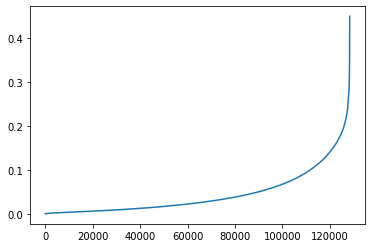

              precision    recall  f1-score   support

           0       0.96      0.90      0.93    120974
           1       0.20      0.43      0.28      7442

    accuracy                           0.87    128416
   macro avg       0.58      0.67      0.60    128416
weighted avg       0.92      0.87      0.89    128416

recall=0.43362
precision=0.20488
f1_score=0.27827


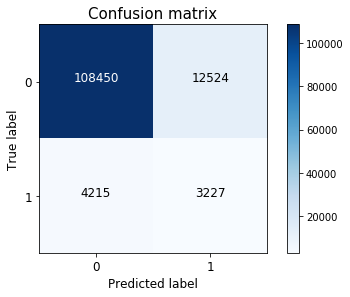

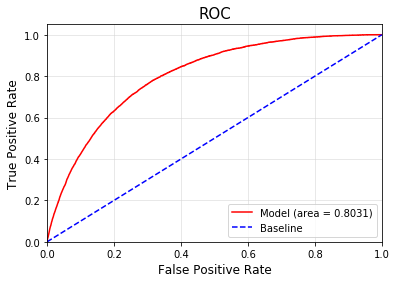

Best Threshold=0.046839
KS:0.468593


In [115]:
y_prob_NN_sort = np.sort(y_prob_NN)
plt.plot(y_prob_NN_sort)
plt.show()

classes = [0,1]
index = 15751
threshold_index = y_prob_NN_sort[-(index+1)]
y_prob, cm = cp_xgb(model, X_test, y_test, threshold_index)
plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix',cmap=plt.cm.Blues)
auc_NN = auc_xgb(model, X_test, y_test)
ROC_xgb(model, X_test, y_test, auc_NN)
print('KS:%.6f' % max(abs(tpr-fpr)))

# Swap Sets and Bad Rates

## Decision Tree

In [43]:
#using percentage as cut-off
index = 15751
y_prob_Dtree_sort = np.sort(y_prob_Dtree)
Dtree_threshold = y_prob_Dtree_sort[-(index+1)]
y_pred_Dtree = np.where(y_prob_Dtree > Dtree_threshold, 1, 0) 
print(Dtree_threshold)

swap_matrix_Dtree = swap_set(y_pred_Dtree)
print()
_= badrate(y_pred_Dtree, swap_matrix_Dtree, y_test)

0.11646447140381283
Swap Sets Matrix
[[108488   4177 112665]
 [  5904   9847  15751]
 [114392  14024 128416]]

Bad Rates Matrix (in %)
[[ 3.432  9.48   3.656]
 [19.275 22.189 21.097]
 [ 4.249 18.404  5.795]]


In [44]:
(y_prob_Dtree == Dtree_threshold).sum()

2724

In [45]:
#use probability cut-off
threshold_prob = 0.1108941788607104 
y_pred_Dtree2 = np.where(y_prob_Dtree > threshold_prob, 1, 0)
swap_Dtree2 = swap_set(y_pred_Dtree2)
print()
_= badrate(y_pred_Dtree, swap_Dtree2, y_test)

Swap Sets Matrix
[[106922   5743 112665]
 [  4635  11116  15751]
 [111557  16859 128416]]

Bad Rates Matrix (in %)
[[ 3.482  6.895  3.656]
 [24.552 19.656 21.097]
 [ 4.357 15.309  5.795]]


## Random Forest

In [46]:
#using percentage as cut-off
y_prob_clf_sort = np.sort(y_prob_clf)
clf_threshold = y_prob_clf_sort[-(index+1)]
y_pred_clf = np.where(y_prob_clf > clf_threshold, 1, 0) 
print(clf_threshold)

swap_matrix_clf = swap_set(y_pred_clf)
print()
_= badrate(y_pred_clf, swap_matrix_clf, y_test)

0.10769579165450655
Swap Sets Matrix
[[110448   2217 112665]
 [  2217  13534  15751]
 [112665  15751 128416]]

Bad Rates Matrix (in %)
[[ 3.46  13.442  3.656]
 [16.103 21.915 21.097]
 [ 3.708 20.722  5.795]]


In [47]:
(y_prob_clf == clf_threshold).sum()

1

In [48]:
#use probability cut-off
threshold_prob = 0.1108941788607104 
y_pred_clf2 = np.where(y_prob_clf > threshold_prob, 1, 0)
swap_clf2 = swap_set(y_pred_clf2)
print()
_= badrate(y_pred_clf, swap_clf2, y_test)

Swap Sets Matrix
[[110874   1791 112665]
 [  2741  13010  15751]
 [113615  14801 128416]]

Bad Rates Matrix (in %)
[[ 3.446 16.639  3.656]
 [13.024 22.798 21.097]
 [ 3.677 22.053  5.795]]


## Gradient Boosting

In [49]:
#using percentage as cut-off
y_prob_gbrt_sort = np.sort(y_prob_gbrt)
gbrt_threshold = y_prob_gbrt_sort[-(index+1)]
y_pred_gbrt = np.where(y_prob_gbrt > gbrt_threshold, 1, 0)

swap_matrix_gbrt = swap_set(y_pred_gbrt)
print()
_= badrate(y_pred_gbrt, swap_matrix_gbrt, y_test)

Swap Sets Matrix
[[110899   1766 112665]
 [  1766  13985  15751]
 [112665  15751 128416]]

Bad Rates Matrix (in %)
[[ 3.497 13.647  3.656]
 [15.912 21.752 21.097]
 [ 3.691 20.843  5.795]]


In [50]:
(y_prob_gbrt == gbrt_threshold).sum()

1

In [51]:
#use probability cut-off
threshold_prob = 0.1108941788607104 
y_pred_gbrt2 = np.where(y_prob_gbrt > threshold_prob, 1, 0)
swap_gbrt2 = swap_set(y_pred_gbrt2)
print()
_= badrate(y_pred_gbrt, swap_gbrt2, y_test)

Swap Sets Matrix
[[111276   1389 112665]
 [  2146  13605  15751]
 [113422  14994 128416]]

Bad Rates Matrix (in %)
[[ 3.485 17.351  3.656]
 [13.094 22.359 21.097]
 [ 3.667 21.895  5.795]]


## XGboost

In [52]:
#using percentage as cut-off
y_prob_xgb_sort = np.sort(y_pred_proba_xgb)
xgb_threshold = y_prob_xgb_sort[-(index+1)]
y_pred_xgb = np.where(y_pred_proba_xgb > xgb_threshold, 1, 0)

sawp_matrix_xgb = swap_set(y_pred_xgb)
print()
_ = badrate(y_pred_xgb, sawp_matrix_xgb, y_test)

Swap Sets Matrix
[[110589   2076 112665]
 [  2076  13675  15751]
 [112665  15751 128416]]

Bad Rates Matrix (in %)
[[ 3.449 14.692  3.656]
 [14.403 22.113 21.097]
 [ 3.651 21.135  5.795]]


In [53]:
(y_pred_proba_xgb == xgb_threshold).sum()

1

In [54]:
#use probability cut-off
threshold_prob = 0.1108941788607104 
y_pred_xgb = np.where(y_pred_proba_xgb > threshold_prob, 1, 0)
swap_xgb2 = swap_set(y_pred_xgb)
print()
_ = badrate(y_pred_xgb, swap_xgb2, y_test)

Swap Sets Matrix
[[109826   2839 112665]
 [  1476  14275  15751]
 [111302  17114 128416]]

Bad Rates Matrix (in %)
[[ 3.386 14.089  3.656]
 [14.634 21.765 21.097]
 [ 3.535 20.492  5.795]]


## Deep Learning

In [116]:
#using percentage as cut-off
y_prob_NN_sort = np.sort(y_prob_NN)
NN_threshold = y_prob_NN_sort[-(index+1)]
y_pred_NN = np.where(y_prob_NN > NN_threshold, 1, 0)

sawp_matrix_NN = swap_set(y_pred_NN)
print()
_ = badrate(y_pred_NN, sawp_matrix_NN, y_test)

Swap Sets Matrix
[[110596   2069 112665]
 [  2069  13682  15751]
 [112665  15751 128416]]

Bad Rates Matrix (in %)
[[ 3.494 12.325  3.656]
 [16.965 21.722 21.097]
 [ 3.741 20.488  5.795]]


# Dollar Value Estimation

## Decision Tree

In [55]:
_ , loss_default_Dtree_list, _, loss_reject_Dtree_list, _, n_t1_Dtree, _, n_t2_Dtree  = dollar_value(Dtree)

when approval rate is 0.95

index: 6420
Model threshold: 0.1419234360410831
cost of T1 error for each loan: 3520
number of T1 error from Logistic Model: 4710
number of T1 error from ML Model: 4600
incremental number of T1 error of ML Model: -110

T1 loss of Logistic Model: 16579200
T1 loss of ML Model: 16192000
T1 incremental credit losses of ML Model: -387200

cost of T2 error for each loan: 40500
number of T2 error from Logistic Model: 5734
number of T2 error from ML Model: 6042
incremental number of T2 error of ML Model: 308

T2 loss of Logistic Model: 232227000
T2 loss of ML Model: 244701000
T2 incremental credit losses of ML Model: 12474000

--------------------------------------------------------------------
when approval rate is 0.925

index: 9631
Model threshold: 0.13765117759388923
cost of T1 error for each loan: 3520
number of T1 error from Logistic Model: 7304
number of T1 error from ML Model: 6255
incremental number of T1 error of ML Model: -1049

T1 loss of Logistic Model:

## Random Forest

In [56]:
_ , loss_default_clf_list, _, loss_reject_clf_list, _ , n_t1_clf, _ , n_t2_clf   = dollar_value(clf)

when approval rate is 0.95

index: 6420
Model threshold: 0.14855720907942407
cost of T1 error for each loan: 3520
number of T1 error from Logistic Model: 4710
number of T1 error from ML Model: 4742
incremental number of T1 error of ML Model: 32

T1 loss of Logistic Model: 16579200
T1 loss of ML Model: 16691840
T1 incremental credit losses of ML Model: 112640

cost of T2 error for each loan: 40500
number of T2 error from Logistic Model: 5734
number of T2 error from ML Model: 5764
incremental number of T2 error of ML Model: 30

T2 loss of Logistic Model: 232227000
T2 loss of ML Model: 233442000
T2 incremental credit losses of ML Model: 1215000

--------------------------------------------------------------------
when approval rate is 0.925

index: 9631
Model threshold: 0.1324826218709068
cost of T1 error for each loan: 3520
number of T1 error from Logistic Model: 7304
number of T1 error from ML Model: 7334
incremental number of T1 error of ML Model: 30

T1 loss of Logistic Model: 2571008

## Gradient Boosting

In [57]:
loss_default_logit_list, loss_default_gbrt_list, loss_reject_logit_list, loss_reject_gbrt_list, n_t1_logit, n_t1_gbrt, n_t2_logit, n_t2_gbrt = dollar_value(gbrt)

when approval rate is 0.95

index: 6420
Model threshold: 0.15645718962459618
cost of T1 error for each loan: 3520
number of T1 error from Logistic Model: 4710
number of T1 error from ML Model: 4742
incremental number of T1 error of ML Model: 32

T1 loss of Logistic Model: 16579200
T1 loss of ML Model: 16691840
T1 incremental credit losses of ML Model: 112640

cost of T2 error for each loan: 40500
number of T2 error from Logistic Model: 5734
number of T2 error from ML Model: 5764
incremental number of T2 error of ML Model: 30

T2 loss of Logistic Model: 232227000
T2 loss of ML Model: 233442000
T2 incremental credit losses of ML Model: 1215000

--------------------------------------------------------------------
when approval rate is 0.925

index: 9631
Model threshold: 0.13604341689291216
cost of T1 error for each loan: 3520
number of T1 error from Logistic Model: 7304
number of T1 error from ML Model: 7332
incremental number of T1 error of ML Model: 28

T1 loss of Logistic Model: 257100

## XGboost

In [58]:
_ , loss_default_xgb_list, _, loss_reject_xgb_list, _, n_t1_xgb, _, n_t2_xgb = dollar_value_xgb(bst)

when approval rate is 0.95

index: 6420
Model threshold: 0.16127056
cost of T1 error for each loan: 3520
number of T1 error from Logistic Model: 4710
number of T1 error from ML Model: 4711
incremental number of T1 error of ML Model: 1

T1 loss of Logistic Model: 16579200
T1 loss of ML Model: 16582720
T1 incremental credit losses of ML Model: 3520

cost of T2 error for each loan: 40500
number of T2 error from Logistic Model: 5734
number of T2 error from ML Model: 5733
incremental number of T2 error of ML Model: -1

T2 loss of Logistic Model: 232227000
T2 loss of ML Model: 232186500
T2 incremental credit losses of ML Model: -40500

--------------------------------------------------------------------
when approval rate is 0.925

index: 9631
Model threshold: 0.14214024
cost of T1 error for each loan: 3520
number of T1 error from Logistic Model: 7304
number of T1 error from ML Model: 7315
incremental number of T1 error of ML Model: 11

T1 loss of Logistic Model: 25710080
T1 loss of ML Model

## Deeping Learning

In [118]:
_ , loss_default_NN_list, _, loss_reject_NN_list, _, n_t1_NN, _, n_t2_NN = dollar_value_xgb(model)

when approval rate is 0.95

index: 6420
Model threshold: 0.16127056
cost of T1 error for each loan: 3520
number of T1 error from Logistic Model: 4710
number of T1 error from ML Model: 4711
incremental number of T1 error of ML Model: 1

T1 loss of Logistic Model: 16579200
T1 loss of ML Model: 16582720
T1 incremental credit losses of ML Model: 3520

cost of T2 error for each loan: 40500
number of T2 error from Logistic Model: 5734
number of T2 error from ML Model: 5733
incremental number of T2 error of ML Model: -1

T2 loss of Logistic Model: 232227000
T2 loss of ML Model: 232186500
T2 incremental credit losses of ML Model: -40500

--------------------------------------------------------------------
when approval rate is 0.925

index: 9631
Model threshold: 0.14214024
cost of T1 error for each loan: 3520
number of T1 error from Logistic Model: 7304
number of T1 error from ML Model: 7315
incremental number of T1 error of ML Model: 11

T1 loss of Logistic Model: 25710080
T1 loss of ML Model

## Plotting T1 and T2 Loss

In [122]:
percentage_range = [0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

loss_all = {'approval rate': map(lambda x:1-x, percentage_range), 
            'loss_default_logit':loss_default_logit_list, 
            'loss_default_Dtree':loss_default_Dtree_list,
            'loss_default_clf':loss_default_clf_list,
            'loss_default_gbrt':loss_default_gbrt_list,
            'loss_default_xgb':loss_default_xgb_list,
            'loss_default_NN':loss_default_NN_list,
           
            'loss_reject_logit':loss_reject_logit_list,
            'loss_reject_Dtree':loss_reject_Dtree_list,
            'loss_reject_clf':loss_reject_clf_list,
            'loss_reject_gbrt':loss_reject_gbrt_list,
            'loss_reject_xgb':loss_reject_xgb_list,
            'loss_reject_NN':loss_reject_NN_list,
            
            'n_t1_logit':n_t1_logit, 
            'n_t1_Dtree':n_t1_Dtree, 
            'n_t1_clf':n_t1_clf, 
            'n_t1_gbrt':n_t1_gbrt, 
            'n_t1_xgb':n_t1_xgb, 
            'n_t1_NN':n_t1_NN,
            
            'n_t2_logit':n_t2_logit, 
            'n_t2_Dtree':n_t2_Dtree, 
            'n_t2_clf':n_t2_clf, 
            'n_t2_gbrt':n_t2_gbrt, 
            'n_t2_xgb':n_t2_xgb, 
            'n_t2_NN':n_t2_NN,
            
           }
loss_all = pd.DataFrame(loss_all)

In [123]:
# T1 error percentage
loss_all['percen_reject_Dtree'] = (loss_all['loss_reject_Dtree']-loss_all['loss_reject_logit'])/loss_all['loss_reject_logit']
loss_all['percen_reject_clf'] = (loss_all['loss_reject_clf']-loss_all['loss_reject_logit'])/loss_all['loss_reject_logit']
loss_all['percen_reject_gbrt'] = (loss_all['loss_reject_gbrt']-loss_all['loss_reject_logit'])/loss_all['loss_reject_logit']
loss_all['percen_reject_xgb'] = (loss_all['loss_reject_xgb']-loss_all['loss_reject_logit'])/loss_all['loss_reject_logit']

# T2 error percentage
loss_all['percen_default_gbrt'] = (loss_all['loss_default_gbrt']-loss_all['loss_default_logit'])/loss_all['loss_default_logit']
loss_all['percen_default_clf'] = (loss_all['loss_default_clf']-loss_all['loss_default_logit'])/loss_all['loss_default_logit']
loss_all['percen_default_Dtree'] = (loss_all['loss_default_Dtree']-loss_all['loss_default_logit'])/loss_all['loss_default_logit']
loss_all['percen_default_xgb'] = (loss_all['loss_default_xgb']-loss_all['loss_default_logit'])/loss_all['loss_default_logit']

# combined percentage
loss_all['percen_cost_Dtree'] = (loss_all['loss_reject_Dtree']+loss_all['loss_default_Dtree']-(loss_all['loss_reject_logit']+loss_all['loss_default_logit']))/(loss_all['loss_reject_logit']+loss_all['loss_default_logit'])
loss_all['percen_cost_clf'] = (loss_all['loss_reject_clf']+loss_all['loss_default_clf']-(loss_all['loss_reject_logit']+loss_all['loss_default_logit']))/(loss_all['loss_reject_logit']+loss_all['loss_default_logit'])
loss_all['percen_cost_gbrt'] = (loss_all['loss_reject_gbrt']+loss_all['loss_default_gbrt']-(loss_all['loss_reject_logit']+loss_all['loss_default_logit']))/(loss_all['loss_reject_logit']+loss_all['loss_default_logit'])
loss_all['percen_cost_xgb'] = (loss_all['loss_reject_xgb']+loss_all['loss_default_xgb']-(loss_all['loss_reject_logit']+loss_all['loss_default_logit']))/(loss_all['loss_reject_logit']+loss_all['loss_default_logit'])

# T1 Difference
loss_all['diff_reject_Dtree'] = (loss_all['loss_reject_Dtree']-loss_all['loss_reject_logit'])
loss_all['diff_reject_clf'] = (loss_all['loss_reject_clf']-loss_all['loss_reject_logit'])
loss_all['diff_reject_gbrt'] = (loss_all['loss_reject_gbrt']-loss_all['loss_reject_logit'])
loss_all['diff_reject_xgb'] = (loss_all['loss_reject_xgb']-loss_all['loss_reject_logit'])
loss_all['diff_reject_NN'] = (loss_all['loss_reject_NN']-loss_all['loss_reject_logit'])

# T2 Difference
loss_all['diff_default_gbrt'] = (loss_all['loss_default_gbrt']-loss_all['loss_default_logit'])
loss_all['diff_default_clf'] = (loss_all['loss_default_clf']-loss_all['loss_default_logit'])
loss_all['diff_default_Dtree'] = (loss_all['loss_default_Dtree']-loss_all['loss_default_logit'])
loss_all['diff_default_xgb'] = (loss_all['loss_default_xgb']-loss_all['loss_default_logit'])
loss_all['diff_default_NN'] = (loss_all['loss_default_NN']-loss_all['loss_default_NN'])

#Combined difference
loss_all['diff_cost_Dtree'] = loss_all['diff_reject_Dtree'] + loss_all['diff_default_Dtree']
loss_all['diff_cost_clf'] = loss_all['diff_reject_clf'] + loss_all['diff_default_clf']
loss_all['diff_cost_gbrt'] = loss_all['diff_reject_gbrt'] + loss_all['diff_default_gbrt']
loss_all['diff_cost_xgb'] = loss_all['diff_reject_xgb'] + loss_all['diff_default_xgb']
loss_all['diff_cost_NN'] = loss_all['diff_reject_NN'] + loss_all['diff_default_NN']




In [61]:
#loss_all.to_csv('loss_all.csv')

In [62]:
#loss_all = pd.read_csv('loss_all.csv')

### Dollar Value Cost of T1 and T2 Error

Text(0, 0.5, 'Dollar Value (Millions)')

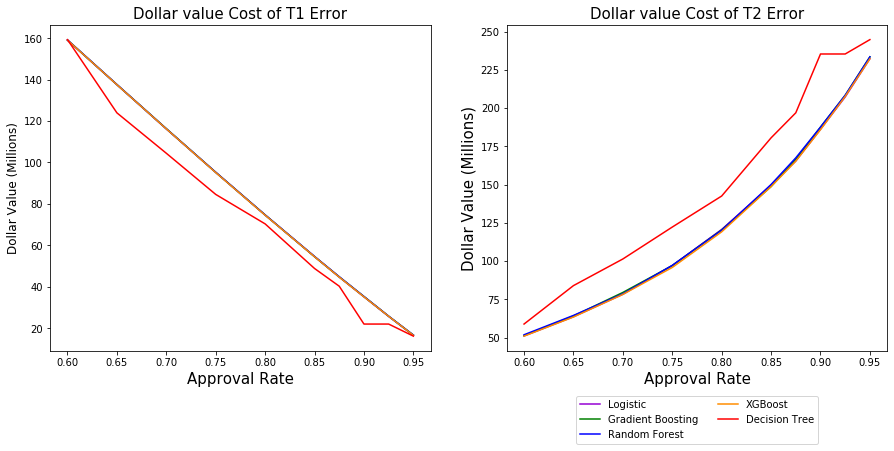

In [130]:
plt.subplots(1,2,figsize=(15,6))
plt.subplot(121)
plt.plot(loss_all['approval rate'], loss_all['loss_reject_logit']/1000000, label = 'Logistic', color = 'darkviolet')
plt.plot(loss_all['approval rate'], loss_all['loss_reject_gbrt']/1000000, label = 'Gradient Boosting', color = 'g')
plt.plot(loss_all['approval rate'], loss_all['loss_reject_clf']/1000000, label = 'Random Forest', color = 'b')
plt.plot(loss_all['approval rate'], loss_all['loss_reject_xgb']/1000000, label = 'XGBoost', color = 'darkorange')
plt.plot(loss_all['approval rate'], loss_all['loss_reject_Dtree']/1000000, label = 'Decision Tree', color = 'r')
#plt.plot(loss_all['approval rate'], loss_all['loss_reject_NN']/1000000, label = 'Neural Network', color = 'r')
plt.title('Dollar value Cost of T1 Error', fontsize=15)
plt.xlabel('Approval Rate', fontsize=15)
plt.ylabel('Dollar Value (Millions)', fontsize=12)

plt.subplot(122)
plt.plot(loss_all['approval rate'], loss_all['loss_default_logit']/1000000, label = 'Logistic', color = 'darkviolet')
plt.plot(loss_all['approval rate'], loss_all['loss_default_gbrt']/1000000, label = 'Gradient Boosting', color = 'g')
plt.plot(loss_all['approval rate'], loss_all['loss_default_clf']/1000000, label = 'Random Forest', color = 'b')
plt.plot(loss_all['approval rate'], loss_all['loss_default_xgb']/1000000, label = 'XGBoost', color = 'darkorange')
plt.plot(loss_all['approval rate'], loss_all['loss_default_Dtree']/1000000, label = 'Decision Tree', color = 'r')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
plt.title('Dollar value Cost of T2 Error', fontsize=15)
plt.xlabel('Approval Rate', fontsize=15)
plt.ylabel('Dollar Value (Millions)', fontsize=15)

Text(0, 0.5, 'Dollar Value (Millions)')

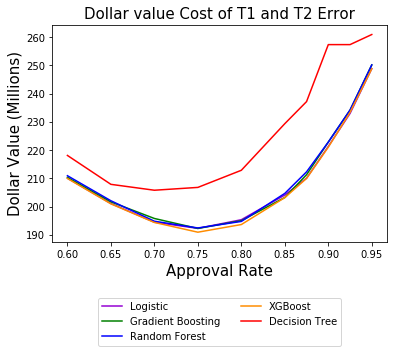

In [131]:
#plt.figure(figsize=(10,8))
plt.plot(loss_all['approval rate'], loss_all['loss_reject_logit']/1000000+loss_all['loss_default_logit']/1000000, label = 'Logistic', color = 'darkviolet')
plt.plot(loss_all['approval rate'], loss_all['loss_reject_gbrt']/1000000+loss_all['loss_default_gbrt']/1000000, label = 'Gradient Boosting', color = 'g')
plt.plot(loss_all['approval rate'], loss_all['loss_reject_clf']/1000000+loss_all['loss_default_clf']/1000000, label = 'Random Forest', color = 'b')
plt.plot(loss_all['approval rate'], loss_all['loss_reject_xgb']/1000000+loss_all['loss_default_xgb']/1000000, label = 'XGBoost', color = 'darkorange')
plt.plot(loss_all['approval rate'], loss_all['loss_reject_Dtree']/1000000+loss_all['loss_default_Dtree']/1000000, label = 'Decision Tree', color = 'r')
#plt.plot(loss_all['approval rate'], loss_all['loss_reject_NN']/1000000+loss_all['loss_default_NN']/1000000, label = 'Neural Network', color = 'lightpink')
plt.title('Dollar value Cost of T1 and T2 Error', fontsize=15)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=2, fancybox=True)
plt.xlabel('Approval Rate', fontsize=15)
plt.ylabel('Dollar Value (Millions)', fontsize=15)

In [64]:
# T1 error percentage
loss_all['percen_reject_Dtree'] = (loss_all['loss_reject_Dtree']-loss_all['loss_reject_logit'])/loss_all['loss_reject_logit']
loss_all['percen_reject_clf'] = (loss_all['loss_reject_clf']-loss_all['loss_reject_logit'])/loss_all['loss_reject_logit']
loss_all['percen_reject_gbrt'] = (loss_all['loss_reject_gbrt']-loss_all['loss_reject_logit'])/loss_all['loss_reject_logit']
loss_all['percen_reject_xgb'] = (loss_all['loss_reject_xgb']-loss_all['loss_reject_logit'])/loss_all['loss_reject_logit']

# T2 error percentage
loss_all['percen_default_gbrt'] = (loss_all['loss_default_gbrt']-loss_all['loss_default_logit'])/loss_all['loss_default_logit']
loss_all['percen_default_clf'] = (loss_all['loss_default_clf']-loss_all['loss_default_logit'])/loss_all['loss_default_logit']
loss_all['percen_default_Dtree'] = (loss_all['loss_default_Dtree']-loss_all['loss_default_logit'])/loss_all['loss_default_logit']
loss_all['percen_default_xgb'] = (loss_all['loss_default_xgb']-loss_all['loss_default_logit'])/loss_all['loss_default_logit']

# combined percentage
loss_all['percen_cost_Dtree'] = (loss_all['loss_reject_Dtree']+loss_all['loss_default_Dtree']-(loss_all['loss_reject_logit']+loss_all['loss_default_logit']))/(loss_all['loss_reject_logit']+loss_all['loss_default_logit'])
loss_all['percen_cost_clf'] = (loss_all['loss_reject_clf']+loss_all['loss_default_clf']-(loss_all['loss_reject_logit']+loss_all['loss_default_logit']))/(loss_all['loss_reject_logit']+loss_all['loss_default_logit'])
loss_all['percen_cost_gbrt'] = (loss_all['loss_reject_gbrt']+loss_all['loss_default_gbrt']-(loss_all['loss_reject_logit']+loss_all['loss_default_logit']))/(loss_all['loss_reject_logit']+loss_all['loss_default_logit'])
loss_all['percen_cost_xgb'] = (loss_all['loss_reject_xgb']+loss_all['loss_default_xgb']-(loss_all['loss_reject_logit']+loss_all['loss_default_logit']))/(loss_all['loss_reject_logit']+loss_all['loss_default_logit'])

# T1 Difference
loss_all['diff_reject_Dtree'] = (loss_all['loss_reject_Dtree']-loss_all['loss_reject_logit'])
loss_all['diff_reject_clf'] = (loss_all['loss_reject_clf']-loss_all['loss_reject_logit'])
loss_all['diff_reject_gbrt'] = (loss_all['loss_reject_gbrt']-loss_all['loss_reject_logit'])
loss_all['diff_reject_xgb'] = (loss_all['loss_reject_xgb']-loss_all['loss_reject_logit'])

# T2 Difference
loss_all['diff_default_gbrt'] = (loss_all['loss_default_gbrt']-loss_all['loss_default_logit'])
loss_all['diff_default_clf'] = (loss_all['loss_default_clf']-loss_all['loss_default_logit'])
loss_all['diff_default_Dtree'] = (loss_all['loss_default_Dtree']-loss_all['loss_default_logit'])
loss_all['diff_default_xgb'] = (loss_all['loss_default_xgb']-loss_all['loss_default_logit'])

loss_all['diff_t1n_Dtree'] = (loss_all['n_t1_Dtree']-loss_all['n_t1_logit'])
loss_all['diff_t1n_clf'] = (loss_all['n_t1_clf']-loss_all['n_t1_logit'])
loss_all['diff_t1n_gbrt'] = (loss_all['n_t1_gbrt']-loss_all['n_t1_logit'])
loss_all['diff_t1n_xgb'] = (loss_all['n_t1_xgb']-loss_all['n_t1_logit'])

loss_all['diff_t2n_Dtree'] = (loss_all['n_t2_Dtree']-loss_all['n_t2_logit'])
loss_all['diff_t2n_clf'] = (loss_all['n_t2_clf']-loss_all['n_t2_logit'])
loss_all['diff_t2n_gbrt'] = (loss_all['n_t2_gbrt']-loss_all['n_t2_logit'])
loss_all['diff_t2n_xgb'] = (loss_all['n_t2_xgb']-loss_all['n_t2_logit'])

In [65]:
loss_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 53 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   approval rate         10 non-null     float64
 1   loss_default_logit    10 non-null     int64  
 2   loss_default_Dtree    10 non-null     int64  
 3   loss_default_clf      10 non-null     int64  
 4   loss_default_gbrt     10 non-null     int64  
 5   loss_default_xgb      10 non-null     int64  
 6   loss_reject_logit     10 non-null     int64  
 7   loss_reject_Dtree     10 non-null     int64  
 8   loss_reject_clf       10 non-null     int64  
 9   loss_reject_gbrt      10 non-null     int64  
 10  loss_reject_xgb       10 non-null     int64  
 11  n_t1_logit            10 non-null     int64  
 12  n_t1_Dtree            10 non-null     int64  
 13  n_t1_clf              10 non-null     int64  
 14  n_t1_gbrt             10 non-null     int64  
 15  n_t1_xgb              10 n

### Percentage Cost of T1 Error

Text(0.5, 0, 'Approval Rate')

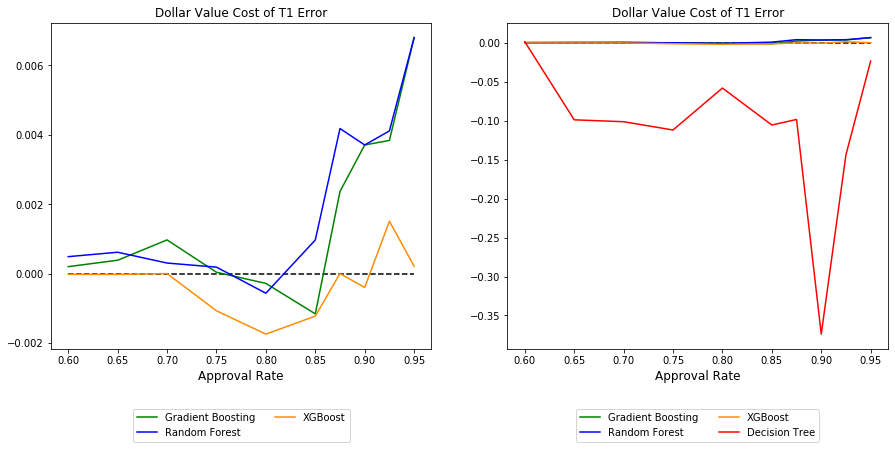

In [66]:
plt.subplots(1,2,figsize=(15,6))
plt.subplot(121)
plt.plot(loss_all['approval rate'], loss_all['percen_reject_gbrt'], color = 'g', label = 'Gradient Boosting')
plt.plot(loss_all['approval rate'], loss_all['percen_reject_clf'], color = 'b', label = 'Random Forest')
#plt.plot(loss_all['approval rate'], loss_all['percen_reject_Dtree'], color = 'r', label = 'Dtree')
plt.plot(loss_all['approval rate'], loss_all['percen_reject_xgb'], color = 'darkorange', label = 'XGBoost')
plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
#plt.ylim(0.2, -0.2)
plt.title('Dollar Value Cost of T1 Error')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
plt.xlabel('Approval Rate', fontsize=12)

plt.subplot(122)
plt.plot(loss_all['approval rate'], loss_all['percen_reject_gbrt'], color = 'g', label = 'Gradient Boosting')
plt.plot(loss_all['approval rate'], loss_all['percen_reject_clf'], color = 'b', label = 'Random Forest')
plt.plot(loss_all['approval rate'], loss_all['percen_reject_xgb'], color = 'darkorange', label = 'XGBoost')
plt.plot(loss_all['approval rate'], loss_all['percen_reject_Dtree'], color = 'r', label = 'Decision Tree')
plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
#plt.ylim(0.2, -0.2)
plt.title('Dollar Value Cost of T1 Error')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
plt.xlabel('Approval Rate', fontsize=12)

### Percentage Cost of T2 Error

Text(0.5, 0, 'Approval Rate')

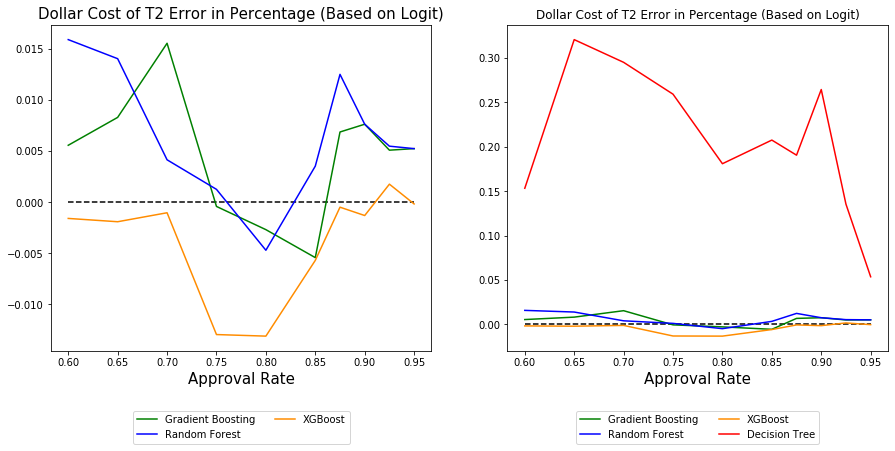

In [71]:
# plt.subplots(1,2,figsize=(15,6))
# plt.subplot(121)
# plt.plot(loss_all['approval rate'], loss_all['percen_default_gbrt'], color = 'g', label = 'Gradient Boosting')
# plt.plot(loss_all['approval rate'], loss_all['percen_default_clf'], color = 'b', label = 'Random Forest')
# #plt.plot(loss_all['approval rate'], loss_all['percen_default_Dtree'], color = 'r', label = 'Dtree')
# plt.plot(loss_all['approval rate'], loss_all['percen_default_xgb'], color = 'darkorange', label = 'XGBoost')
# plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
# #plt.ylim(0.2, -0.2)
# plt.title('Dollar Cost of T2 Error in Percentage (Based on Logit)', fontsize = 15)
# plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
# plt.xlabel('Approval Rate', fontsize=15)

# plt.subplot(122)
# plt.plot(loss_all['approval rate'], loss_all['percen_default_gbrt'], color = 'g', label = 'Gradient Boosting')
# plt.plot(loss_all['approval rate'], loss_all['percen_default_clf'], color = 'b', label = 'Random Forest')
# plt.plot(loss_all['approval rate'], loss_all['percen_default_xgb'], color = 'darkorange', label = 'XGBoost')
# plt.plot(loss_all['approval rate'], loss_all['percen_default_Dtree'], color = 'r', label = 'Decision Tree')
# plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
# #plt.ylim(0.2, -0.2)
# plt.title('Dollar Cost of T2 Error in Percentage (Based on Logit)')
# plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
# plt.xlabel('Approval Rate', fontsize=15)

### Percentage Cost of T1 and T2 Error

Text(0.5, 0, 'Approval Rate')

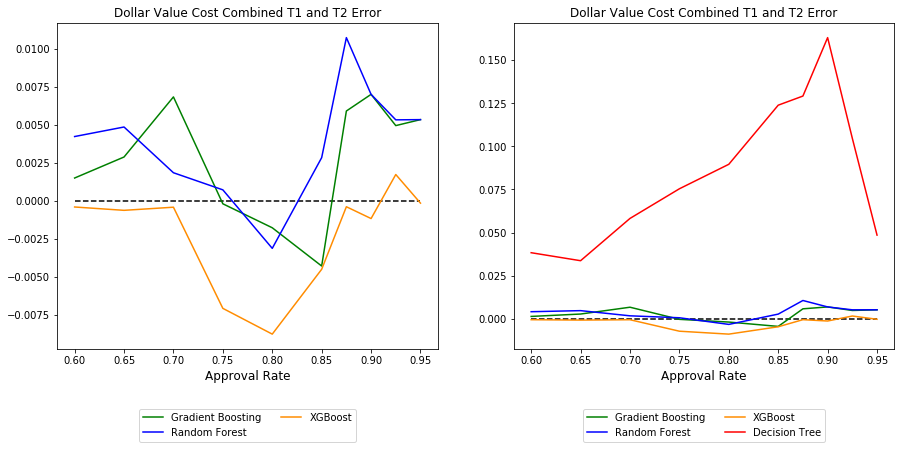

In [72]:
# plt.subplots(1,2,figsize=(15,6))
# plt.subplot(121)
# plt.plot(loss_all['approval rate'], loss_all['percen_cost_gbrt'], color = 'g', label = 'Gradient Boosting')
# plt.plot(loss_all['approval rate'], loss_all['percen_cost_clf'], color = 'b', label = 'Random Forest')
# #plt.plot(loss_all['approval rate'], loss_all['percen_cost_Dtree'], color = 'r', label = 'Dtree')
# plt.plot(loss_all['approval rate'], loss_all['percen_cost_xgb'], color = 'darkorange', label = 'XGBoost')
# plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
# #plt.ylim(0.2, -0.2)
# plt.title('Dollar Value Cost Combined T1 and T2 Error')
# plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
# plt.xlabel('Approval Rate', fontsize=12)

# plt.subplot(122)
# plt.plot(loss_all['approval rate'], loss_all['percen_cost_gbrt'], color = 'g', label = 'Gradient Boosting')
# plt.plot(loss_all['approval rate'], loss_all['percen_cost_clf'], color = 'b', label = 'Random Forest')
# plt.plot(loss_all['approval rate'], loss_all['percen_cost_xgb'], color = 'darkorange', label = 'XGBoost')
# plt.plot(loss_all['approval rate'], loss_all['percen_cost_Dtree'], color = 'r', label = 'Decision Tree')
# plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
# #plt.ylim(0.2, -0.2)
# plt.title('Dollar Value Cost Combined T1 and T2 Error')
# plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
# plt.xlabel('Approval Rate', fontsize=12)

In [ ]:
loss_all

### Different Cost of T1 Error

Text(0, 0.5, 'Dollar Value (Millions)')

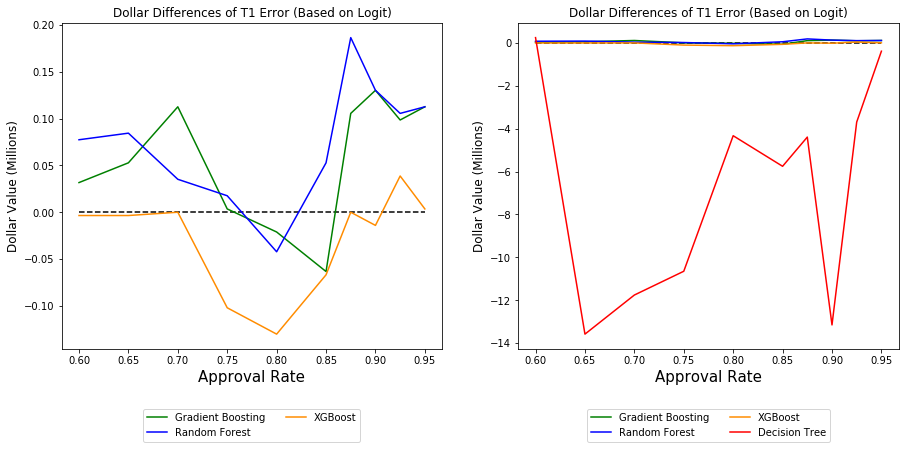

In [73]:
plt.subplots(1,2,figsize=(15,6))
plt.subplot(121)
plt.plot(loss_all['approval rate'], loss_all['diff_reject_gbrt']/1000000, color = 'g', label = 'Gradient Boosting')
plt.plot(loss_all['approval rate'], loss_all['diff_reject_clf']/1000000, color = 'b', label = 'Random Forest')
#plt.plot(loss_all['approval rate'], loss_all['diff_reject_Dtree'], color = 'r', label = 'Dtree')
plt.plot(loss_all['approval rate'], loss_all['diff_reject_xgb']/1000000, color = 'darkorange', label = 'XGBoost')
plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
#plt.ylim(0.2, -0.2)
plt.title('Dollar Differences of T1 Error (Based on Logit)')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
plt.xlabel('Approval Rate', fontsize=15)
plt.ylabel('Dollar Value (Millions)', fontsize=12)

plt.subplot(122)
plt.plot(loss_all['approval rate'], loss_all['diff_reject_gbrt']/1000000, color = 'g', label = 'Gradient Boosting')
plt.plot(loss_all['approval rate'], loss_all['diff_reject_clf']/1000000, color = 'b', label = 'Random Forest')
plt.plot(loss_all['approval rate'], loss_all['diff_reject_xgb']/1000000, color = 'darkorange', label = 'XGBoost')
plt.plot(loss_all['approval rate'], loss_all['diff_reject_Dtree']/1000000, color = 'r', label = 'Decision Tree')
plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
#plt.ylim(0.2, -0.2)
plt.title('Dollar Differences of T1 Error (Based on Logit)')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
plt.xlabel('Approval Rate', fontsize=15)
plt.ylabel('Dollar Value (Millions)', fontsize=12)

### Different Cost of T2 Error

Text(0, 0.5, 'Dollar Value (Millions)')

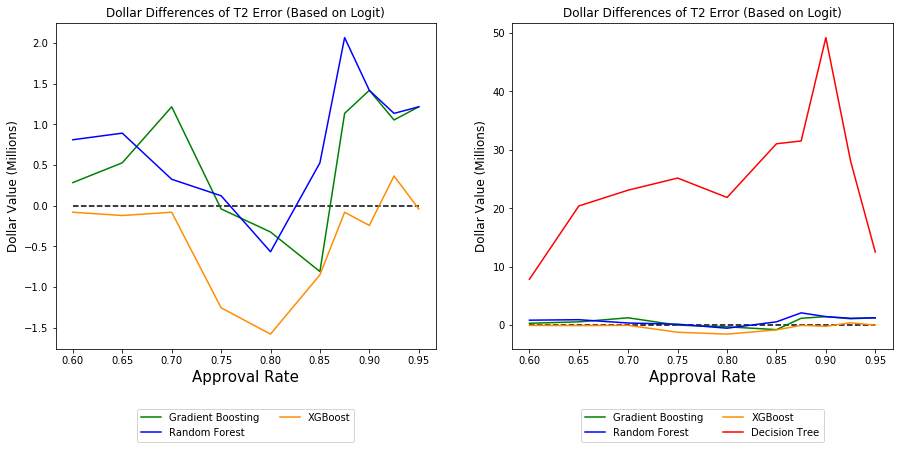

In [74]:
plt.subplots(1,2,figsize=(15,6))
plt.subplot(121)
plt.plot(loss_all['approval rate'], loss_all['diff_default_gbrt']/1000000, color = 'g', label = 'Gradient Boosting')
plt.plot(loss_all['approval rate'], loss_all['diff_default_clf']/1000000, color = 'b', label = 'Random Forest')
#plt.plot(loss_all['approval rate'], loss_all['diff_default_Dtree'], color = 'r', label = 'Dtree')
plt.plot(loss_all['approval rate'], loss_all['diff_default_xgb']/1000000, color = 'darkorange', label = 'XGBoost')
plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
#plt.ylim(0.2, -0.2)
plt.title('Dollar Differences of T2 Error (Based on Logit)')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
plt.xlabel('Approval Rate', fontsize=15)
plt.ylabel('Dollar Value (Millions)', fontsize=12)

plt.subplot(122)
plt.plot(loss_all['approval rate'], loss_all['diff_default_gbrt']/1000000, color = 'g', label = 'Gradient Boosting')
plt.plot(loss_all['approval rate'], loss_all['diff_default_clf']/1000000, color = 'b', label = 'Random Forest')
plt.plot(loss_all['approval rate'], loss_all['diff_default_xgb']/1000000, color = 'darkorange', label = 'XGBoost')
plt.plot(loss_all['approval rate'], loss_all['diff_default_Dtree']/1000000, color = 'r', label = 'Decision Tree')
plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
#plt.ylim(0.2, -0.2)
plt.title('Dollar Differences of T2 Error (Based on Logit)')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
plt.xlabel('Approval Rate', fontsize=15)
plt.ylabel('Dollar Value (Millions)', fontsize=12)

### Different Cost of T1 and T2 Error

Text(0, 0.5, 'Dollar Value (Millions)')

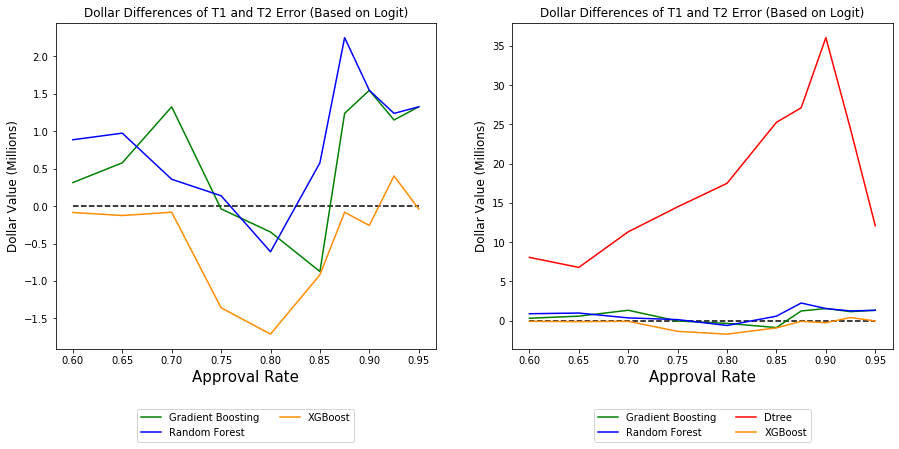

In [132]:
plt.subplots(1,2,figsize=(15,6))
plt.subplot(121)
plt.plot(loss_all['approval rate'], loss_all['diff_cost_gbrt']/1000000, color = 'g', label = 'Gradient Boosting')
plt.plot(loss_all['approval rate'], loss_all['diff_cost_clf']/1000000, color = 'b', label = 'Random Forest')
#plt.plot(loss_all['approval rate'], loss_all['diff_cost_Dtree'], color = 'r', label = 'Dtree')
plt.plot(loss_all['approval rate'], loss_all['diff_cost_xgb']/1000000, color = 'darkorange', label = 'XGBoost')
#plt.plot(loss_all['approval rate'], loss_all['diff_cost_NN']/1000000, color = 'firebrick', label = 'Neural Network')
plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
#plt.ylim(0.2, -0.2)
plt.title('Dollar Differences of T1 and T2 Error (Based on Logit)')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
plt.xlabel('Approval Rate', fontsize=15)
plt.ylabel('Dollar Value (Millions)', fontsize=12)

plt.subplot(122)
plt.plot(loss_all['approval rate'], loss_all['diff_cost_gbrt']/1000000, color = 'g', label = 'Gradient Boosting')
plt.plot(loss_all['approval rate'], loss_all['diff_cost_clf']/1000000, color = 'b', label = 'Random Forest')
plt.plot(loss_all['approval rate'], loss_all['diff_cost_Dtree']/1000000, color = 'r', label = 'Dtree')
plt.plot(loss_all['approval rate'], loss_all['diff_cost_xgb']/1000000, color = 'darkorange', label = 'XGBoost')
plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
#plt.ylim(0.2, -0.2)
plt.title('Dollar Differences of T1 and T2 Error (Based on Logit)')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
plt.xlabel('Approval Rate', fontsize=15)
plt.ylabel('Dollar Value (Millions)', fontsize=12)

Text(0, 0.5, 'Dollar Value (Millions)')

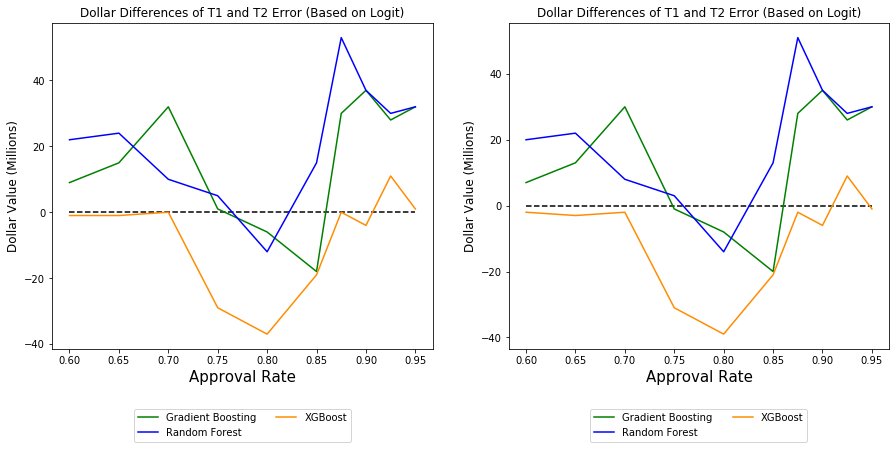

In [76]:
# n_diff
plt.subplots(1,2,figsize=(15,6))
plt.subplot(121)
plt.plot(loss_all['approval rate'], loss_all['diff_t1n_gbrt'], color = 'g', label = 'Gradient Boosting')
plt.plot(loss_all['approval rate'], loss_all['diff_t1n_clf'], color = 'b', label = 'Random Forest')
#plt.plot(loss_all['approval rate'], loss_all['diff_t1n_Dtree'], color = 'r', label = 'Dtree')
plt.plot(loss_all['approval rate'], loss_all['diff_t1n_xgb'], color = 'darkorange', label = 'XGBoost')
plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
#plt.ylim(0.2, -0.2)
plt.title('Dollar Differences of T1 and T2 Error (Based on Logit)')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
plt.xlabel('Approval Rate', fontsize=15)
plt.ylabel('Dollar Value (Millions)', fontsize=12)


plt.subplot(122)
plt.plot(loss_all['approval rate'], loss_all['diff_t2n_gbrt'], color = 'g', label = 'Gradient Boosting')
plt.plot(loss_all['approval rate'], loss_all['diff_t2n_clf'], color = 'b', label = 'Random Forest')
#plt.plot(loss_all['approval rate'], loss_all['diff_t2n_Dtree'], color = 'r', label = 'Dtree')
plt.plot(loss_all['approval rate'], loss_all['diff_t2n_xgb'], color = 'darkorange', label = 'XGBoost')
plt.hlines(0, min(loss_all['approval rate']), max(loss_all['approval rate']), linestyles = 'dashed')
#plt.ylim(0.2, -0.2)
plt.title('Dollar Differences of T1 and T2 Error (Based on Logit)')
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fancybox=True)
plt.xlabel('Approval Rate', fontsize=15)
plt.ylabel('Dollar Value (Millions)', fontsize=12)


